**Initialization**

In [12]:
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

**Task 1: Data set**


In [14]:
# Description: Function to convert the string tensor into a usable tensor that contains the one-hot-encoded sequence 
#              (4 digits for each letter (250 letters per input) -> all in all 1000 input nodes).
#              @parameters: string_tensor
#              @returns: one_hot_enc_vector
def onehotify(string_tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    string_tensor = tf.strings.regex_replace(string_tensor, key, vocab[key])
  split = tf.strings.bytes_split(string_tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  one_hot_enc_vector = tf.one_hot(labels, 4)
  one_hot_enc_vector = tf.reshape(one_hot_enc_vector, (-1,))
  return one_hot_enc_vector

In [16]:
# Description: In this part the training- (100.000 examples) and test data (1.000 examples) is downloaded as two seperated tensorflow datasets.
#              These have a 2-tuple structure (input, target). In the next steps the data is prepared. Therefore the map-function is used to apply the 
#              "convertion-functions", which return the inputs and targets as one-hot-encoded sequenzes, to each single element in the datasets. 
#              Additionally, the originally two datasets are separated into inputs and targets datasets each. Afterwards, the separated datasets for 
#              inputs and targets are merged again into one training- and one test dataset. Lastly, these datasets are batched and prefetched.
batch_size = 100

training_data, test_data = tfds.load('genomics_ood', split = ['train[:100000]', 'test[:1000]'], as_supervised = True)


training_dataset_inputs = training_data.map(lambda inputs, targets: onehotify(inputs))
training_dataset_targets = training_data.map(lambda inputs, targets: tf.one_hot(targets, 10))

test_dataset_inputs = test_data.map(lambda inputs, targets: onehotify(inputs))
test_dataset_targets = test_data.map(lambda inputs, targets: tf.one_hot(targets, 10))


training_dataset = tf.data.Dataset.zip((training_dataset_inputs, training_dataset_targets))
training_dataset = training_dataset.batch(batch_size).prefetch(2)

test_dataset = tf.data.Dataset.zip((test_dataset_inputs, test_dataset_targets))
test_dataset = test_dataset.batch(batch_size).prefetch(2)     

**Task 2: Model**

In [17]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

# Description: The class Model describes a multi-layer perceptron with two hidden layers and one output layer.
#              @class variables: -
#              @object variables: hidden_layer_1, hidden_layer_2, output_layer
#              @functions: call
class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)


    # Description: This function conducts one forward-step of the model. 
    #              A python decorator (@tf.function) is used to bundle multiple computations into one computational graph.
    #              @parameters: input
    #              @returns: prediction
    @tf.function
    def call(self, input):
        activ_hidden_1 = self.hidden_layer_1(input)
        activ_hidden_2 = self.hidden_layer_2(activ_hidden_1)
        prediction = self.output_layer(activ_hidden_2)
        return prediction

**Task 3: Training**

In [18]:
# Description: This function trains an object of the class Model. It conducts a forward-step and the backpropagation 
#              throughout the network. Additionally, it determines the average training loss and accuracy.
#              @parameters: mlp, training_data, loss_fn, optimizer
#              @returns: training_loss, training_accuracy
def training_step(mlp, training_data, loss_fn, optimizer):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = mlp(input)
      current_training_loss = loss_fn(target, prediction)
      gradients = tape.gradient(current_training_loss, mlp.trainable_variables)
      optimizer.apply_gradients(zip(gradients, mlp.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))   
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy


# Description: This function determines the average test loss and accuracy of an object of the class Model.
#              @parameters: mlp, test_data, loss_fn
#              @returns: test_loss, test_accuracy
def test(mlp, test_data, loss_fn):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = mlp(input)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

In [20]:
# Description: This part creates an object of the class Model called mlp and executes the training and testing of the mlp in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
tf.keras.backend.clear_session()

mlp = Model()
n_epochs = 10
learning_rate = 0.1
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate)    # SGD = Standard Gradient Descent

training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))

    # Shuffles the datasets in each epoch to ensure that the order of the inputs is always changed.
    training_dataset = training_dataset.shuffle(buffer_size = batch_size)
    test_dataset = test_dataset.shuffle(buffer_size = batch_size)

    training_loss, training_accuracy = training_step(mlp, training_dataset, loss_fn, optimizer)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(mlp, test_dataset, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


**Task 4: Visualization**

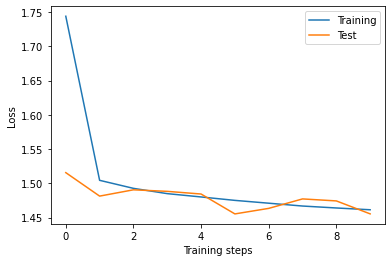

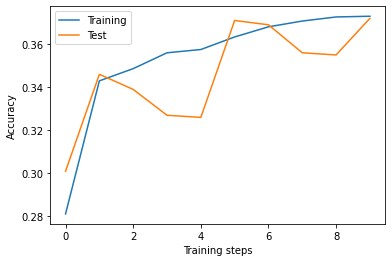

In [21]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the mlp.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the mlp.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()